# Chapter 1: Umbrella sampling

#### Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

If you're interested, check my website for more future posts/tutorials about advanced sampling methods!

In this exercise, our goal is to perform umbrella sampling for NaCl to compute its free energy as a function of the ion-pair distance, which is an intuitive collective variable (CV) relevant to the dissociation process of NaCl. Umbrella sampling is composed of the following 2 steps that we will elaborate on later:

- **Step 1**: A pulling simulation (a.k.a a steered MD simulation) for generating initial configurations for the production runs.
- **Step 2**: Production runs that fix the configurations with harmonic potentials.


Please visit the [article](https://weitsehsu.com/course/advanced_sampling/us/) accompanying this tutorial if you are interested in more comprehensive discussions about the method. 

## 1. Setting things up
In the folder `Systems/NaCl` in the course repository, you can find simulation inputs that we need for this tutorial, though some may need some modifications. Files required for this exercise include `NaCl.gro`, `NaCl.top`, and `MD_NVT.mdp`. For more details about these files, please visit the [README file](https://github.com/wehs7661/advanced_sampling_tutorials/tree/master/Systems#nacl-system) for the system. To get started, we remove the output folders/files of the exercise with the following bash commands, if any:

In [1]:
%%bash
dirs=(sim_* pull* *mdp *dat results)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

mkdir results

## 2. Pulling simulation
As a reminder, the purpose of a pulling simulation is to generate configurations with different values of CV (the ion-pair distance in this case). The generated configurations will be used as the initial configurations in the subsequent production simulations. In a pulling simulation, we need to make the following two decisions:

- **Defining the pull groups**: The pull groups are groups of atom(s) we exert the pulling force between. Here, we define the sodium and chloride ions as the pull groups. In GROMACS, this setup can be done by adding **pull codes** to the `.mdp` file, as we will detail later.
- **Choosing the immobile group**: In umbrella sampling, it is common to apply a position restraint to one of the pull groups to make the pulling process more efficient. In our case, we will choose to fix the position of the sodium ion, but fixing the chloride ion should not make a difference in the resulting free energy profile. As we will see in later, the application of the position restraint can be done by modifying the `.top` file.

Here, we first create a folder `pull` specifically for the pulling simulation, and copy over `NaCl.gro` from the folder `Systems/NaCl`:

In [2]:
%%bash
mkdir pull

In the following subsections, we modify the `.top` file and the `.mdp` file to apply a position restraint and the pull code, respectively.

### 2-1. Modification of the `top` file

The `.top` file we have in `Systems/NaCl`, `NaCl.top`, is for standard MD simulations, which has the following content:

In [3]:
%%bash
cat ../Systems/NaCl/NaCl.top

#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1


To apply a position restraint, one needs to add the following lines before the `[ System ]` directive:

```
; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif
```

In [4]:
%%bash 
echo '#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1' > pull/NaCl_US.top

These lines mean that if the variable `POSRES_NA` is defined in the `.mdp` file for the pulling simulation, the position restraint defined in the file `Na_posres.itp` will be activated. The `.itp` file `Na_posres.itp` can be generated and saved in the folder `pull` by the Bash commands below. (For more details about GROMACS `.itp` file and the `ifdef` statements, please refer to the GROMACS [reference manual](https://manual.gromacs.org/current/reference-manual/topologies/topology-file-formats.html#molecule-itp-file).)

In [5]:
%%bash 
cp ../Systems/NaCl/NaCl.gro pull/.    # copy over the gro file by the way
echo '[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000' > pull/Na_posres.itp

Here are more details about the columns in the `[ position_restraints ]` directive:
- `i`: The index of the atom (in the `[ moleculetype ]` directive) to which the position restraint is applied. Note that the `[ position_restraint ]` directive is under the `[ moleculetype ]` directive, so even if the index of the sodium ion in `NaCl.gro` is 322, it is the first (and only) atom in the `[ moleculetype ]` that corresponds to `NA`, so we specify the value of `i` as 1 (instead of 322) here.
- `funct`: The function type of the restraint. Type `1` corresponds to a harmonic potential.
- `fcx`, `fcy`, and `fcz`: The force constants along $x$, $y$, and $z$ directions, respectively, meausred in $\mathrm{kJ/mol/nm^2}$. These constants define how strongly the atom is pulled back to its reference position (the initial position) when it moves. The default of $1000$ $\mathrm{kJ/mol/nm^2}$ should be generally sufficient.

Notably, in more complicated cases, such as pulling two chains of protein molecules apart, you may need to restrain not just one atom (as in our example here) but multiple ones, in which case the GROMACS `genrestr` command could be useful. For more details, please check the supplementary note in the accompanying article. 

### 2-2. Modification of the `mdp` file

Here, we will create the `.mdp` file for the pulling simulation (saved in the folder `pull` as `NaCl_pull.mdp`) by modifying the `.mdp` template for standard molecular dynamics, `MD-NVT.mdp` in `Systems/NaCl`. The `.mdp` template has the following parameters:

In [6]:
%%bash
cat ../Systems/NaCl/MD-NVT.mdp  # the original MDP file

integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
DispCorr = AllEnerPres
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000


Note that here we adopt smaller cutoffs than usual for the neighbor list (`rlist`) and for the interactions (`rcoulomb` and `rvdw`) just so that we can use a smaller simulation box for the system, which makes this example simulation affordable even on a laptop. We set the simulation length as 250 ps, which should be sufficient for our case. In addition, the simulation will be performed in the NVT ensemble.

To suit the need of running a pulling simulation, we first need to define `POSRES_NA` in the `.mdp` file so the position restraint is activated. This can be done by adding the following line to the `.mdp` file.
```
define=-DPOSRES_NA
```

In [7]:
%%bash
echo 'define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 125000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000
' > pull/NaCl_pull.mdp
# Here we create an mdp file starting with `define=-DPOSRES_NA`

Then, to pull the chloride ion away, we need to add the following pull code to the `.mdp` file:

In [8]:
%%bash
echo '; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; The harmonic potential is centered at the initial COM distance. 
pull-coord1-rate = 0.0010         ; 0.0010 nm/ps -> pull distance in the 250 ps-simulation: 0.25 nm.
pull-coord1-k = 1000              ; units: kJ/mol/nm^2' >> pull/NaCl_pull.mdp

As shown above, parameters in the code block come with simple explanations. Below are some additional explanations for some of the parameters:
- `pull-coord1-rate`: The rate at which the imaginary spring attached between the ions is elongated. Importantly, the pull distance must not exceed 0.7248 nm, which is half of the smallest dimension of the simulation box. (As can be checked in `pull/NaCl.gro`, the simulation box we use is a cubic box with a side length of 1.48561 nm.) This is to prevent the pull group from interacting with the periodic image of the system. Given that the typical ion-pair distance of NaCl is 0.265 nm, a total pull distance of 0.25 nm should be safe.
- `pull-coord1-k`: The force constant does not really matter in the pulling simulation as long as it is large enough to pull the pull groups apart. 

For other possible options/parameters for pulling, please refer to GROMACS [reference manual](https://manual.gromacs.org/documentation/current/user-guide/mdp-options.html#com-pulling).

### 2-3. Running a pulling simulation

With all the input files prepared in the `pull` folder (including `NaCl.gro`, `NaCl.top`, and `NaCl_pull.mdp`), we can finally run the pulling simulation. Note that depending on the version of GROMACS you are using, you might need a different `grompp` command.

#### Versions earlier than 2022
Simply executing the following command should be fine:
  ```bash
  mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -maxwarn 1
  mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1
  ```

#### Versions later than 2022
Here we are using GROMACS 2022.5, in which case the `grompp` command above might fail with the following error:
  ```
  Fatal error:
  Group NA referenced in the .mdp file was not found in the index file.
  Group names must match either [moleculetype] names or custom index group
  names, in which case you must supply an index file to the '-n' option
  of grompp.
  ```
  To resolve this, we need to create an index file where both the groups `NA` and `CL` referenced by `pull-group1-name` and `pull-group2-name` in the `.mdp` file are available, then pass the index file to the `grompp` command. To do this, execute the following command:

In [9]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
echo -e 'a 322\nname 6 NA\na323\nname 7 CL\nq' | mpirun -np 1 gmx_mpi make_ndx -f pull/NaCl.gro -o pull/NaCl.ndx

Going to read 0 old index file(s)
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues

  0 System              :   323 atoms
  1 Water               :   321 atoms
  2 SOL                 :   321 atoms
  3 non-Water           :     2 atoms
  4 Ion                 :     2 atoms
  5 Water_and_ions      :   323 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 

  6 a_322               :     1 atoms

> 

> 

  7 a_323               :     1 atoms

> 

> 


         :-) GROMACS - gmx make_ndx, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi make_ndx -f pull/NaCl.gro -o pull/NaCl.ndx


Reading structure file

GROMACS reminds you: "May the Force Be With You" (Star Wars)



In [10]:
%%time
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -n pull/NaCl.ndx -maxwarn 1

Setting the LD random seed to -615008262

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -46700809

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the rel

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -n pull/NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file pull/NaCl_pull.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
    

CPU times: user 3.17 ms, sys: 4.67 ms, total: 7.83 ms
Wall time: 528 ms


In [11]:
%%time
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

          :-) GROMACS - gmx mdrun, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

Reading file pull/pull.tpr, VERSION 2022.5-dev-20230428-fdf57150ad (single precision)
Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

Using 1 MPI process
starting mdrun 'NaCl in water'
125000 steps,    250.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:       20.140       20.140      100.0
                 (ns/day)    (hour/ns)
Performance:     1072.509        0.022

GROMACS reminds you: "There is no such thing as free energy. Anyone who advocates it does not know what he is talking about." (Alireza Haghighat)



CPU times: user 3.72 ms, sys: 5.3 ms, total: 9.02 ms
Wall time: 20.4 s


Note that in both cases, the `-r` flag is required for the restraint. In addition, compared to a standard MD simulation, a pulling simulation has two additional output files: `pullf.xvg` and `pullx.xvg`, which document the time series of the pulling force and ion-pair distance.

### 2-4. Generation of the initial configurations

Before generating the initial configurations from the pulling simulation, we first need to decide the number of windows to use for the next step. This requires experience and sometimes trials and errors, but what's generally more important is the overlap in the probability distributions between neighboring windows, as we will explore in the next section when specifying force constants. For NaCl, 8 windows should be sufficient. 

To ensure overlap in probability distributions corresponding to neighboring windows, it is common to linearly divide the reaction path when deciding the centers of the windows, which might not always be optimal but should serve as a decent starting point. In our case, we define the equally spaced centers with the ion-pair distance ranging from the minimum value observed in the pulling simulation up to 0.6 nm. Depending on the force constants we want to use in the next section for umbrella localization, the center of the last window, hence its probability distribution, should not be too close to the upper bound (i.e., 0.7248 nm) so that a configuration with a CV value exceeding the upper bound is unlikely. 

Below we use a Python script to identify the time frames in the pulling simulation at which the configuration has a CV value close to the desired value, i.e., the predefined center of the window.

In [12]:
import numpy as np
pullx = np.transpose(np.loadtxt('pull/pullx.xvg', comments=['@', '#']))
t, dist = pullx[0], pullx[1]
centers = np.linspace(min(dist), 0.6, 8)  # the spacing between windows should be around 0.05 nm
diff_list = np.abs([dist - i for i in centers])
diff_idx = [np.argmin(diff_list[i]) for i in range(len(centers))]  # dist[diff_idx]: distances closet to the centers
t_extract = t[diff_idx]  # in ps
print(f'The ion-pair distances (in nm) of the chosen configurations are: {dist[diff_idx]}')
print(f'The initial configurations will be extracted from the following time frames (in ps): {t_extract}')

The ion-pair distances (in nm) of the chosen configurations are: [0.248848 0.29903  0.349314 0.39936  0.449456 0.499348 0.549502 0.599458]
The initial configurations will be extracted from the following time frames (in ps): [ 28.8  58.8 128.1 100.2 139.3 156.6 235.6 247.3]


Then, to extract the configurations corresponding to the chosen time frames, we run the following Python script:

In [13]:
import os
for i in range(len(t_extract)):
    os.mkdir(f'sim_{i}')
    os.system(f'source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC && echo System | mpirun -np 1 gmx_mpi trjconv -s pull/pull.tpr -f pull/pull.xtc -dump {t_extract[i]} -o sim_{i}/NaCl_{i}.gro')

Upon completion of the script, you should have folders named in the form of `sim_*`, with a `.gro` file `NaCl_*.gro` in each of them. These 8 folders correspond to the 8 windows we will use in the production simulations, which are seeded by the `.gro` files in the folders.

## 3. Production runs

In the previous step, we prepared the 8 input `.gro` files for the 8 simulations in the production stage, which will use the same topology file `NaCl_US.top` as we used for the pulling simulation. Still, we need to prepare the `.mdp` file `NaCl_umbrella.mdp` shared by all the 8 simulations. Compared to the `.mdp` file we used for the pulling simulation, `NaCl_umbrella.mdp` has the following 3 differences:
- The simulation length is 500 ps instead of 250 ps.
- The pull rate is set as 0, since we need to localize each configuration at a different ion-pair distance.
- The force constant is set as 8000 instead of 1000 $\mathrm{kJ/mo/nm^2}$. Again, the determination of the force constant requires experience and sometimes trials and errors. We will discucss how the force constant should be adjusted if the simulation results are not ideal. 

We can use the following bash commands to make the changes:

In [14]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 8000/g" NaCl_umbrella.mdp
cat NaCl_umbrella.mdp

define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000

; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           

All 8 simulations use the same `.top` file (which requires the `.itp` file `Na_posres.itp`) and `.mdp` file. In the script below, we distribute the input files to different `sim_*` folders, and for each of them, we run the GROMACS `grompp` command to generate the `.tpr` file and the `mdrun` command to run the simulation. 

In [15]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp pull/NaCl.ndx sim_${i}/.       # This line is only needed for GROMACS with a version later than 2022
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

Setting the LD random seed to -1290797089

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -1246792711

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the 

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1/sim_0
Command line:
  gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_0.gro -r NaCl_0.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.

The commands above assume a GROMACS version later than 2022. If you are using an earlier version, you don't need to copy over the `.ndx` file and pass it to the `grompp` command. Notably, if you have more than 8 CPU cores, you can run all 8 simulations in parallel using the `-multidir`, which would be faster but also require MPI-enabled GROMACS.

```
mpirun -np 8 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -multidir sim_{0..7}
```

## 4. Data analysis

### 4-1. Distributions of the pulling distance 

One indicator for assessing the quality of the production simulations and whether we need to adjust the parameters (e.g., the number of windows and force constants) is the overlap between neighboring replicas. Using the `pullx.xvg` file from each simulation in each folder, we can use the following code to visualize the distribution of the pulling distance for each simulation.

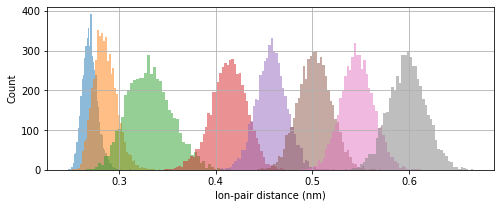

In [16]:
import matplotlib.pyplot as plt
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

As shown in the figure above, there is an overlap between every pair of neighboring windows, indicating that a force constant of 8000 $\mathrm{kJ/mol/nm^2}$ is reasonable.

Below are the codes I used to generate the figure in the article if you are interested.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

In [18]:
def setup_coordinates(ax, color):
    ax.spines['top'].set_color(color)
    ax.spines['bottom'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(color=color, labelcolor=color)

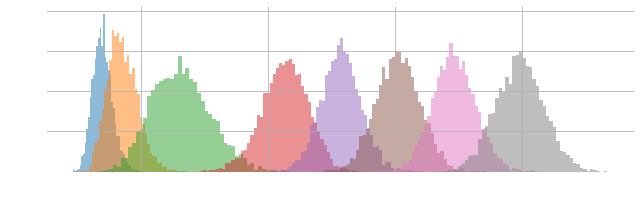

In [19]:
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
setup_coordinates(ax, color='white')
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)', color='white')
plt.ylabel('Count', color='white')
plt.grid()
plt.tight_layout()
plt.savefig('results/pullx_distribution.png', transparent=True, dpi=600)

### 4-2. Free energy calculations

Once we have confirmed comprehensive coverage for the entire CV range of interest, we can proceed with free energy calculations. For umbrella sampling, various free energy estimators could be used, including WHAM, TI, BAR, MBAR, and others like UWHAM, SWHAM, and FastMBAR. Since MBAR is provably the lowest variance unbiased estimator, we will use it here to perform free energy calculations.

To perform free energy calculations and plot the free energy profile, run the following script:

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


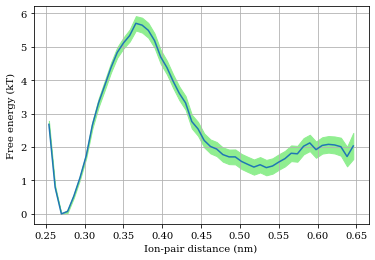

In [20]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
K_k = np.ones(K) * 8000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

Also, to plot the histograms of the number of uncorrelated samples for different CV values, one can use the following script:

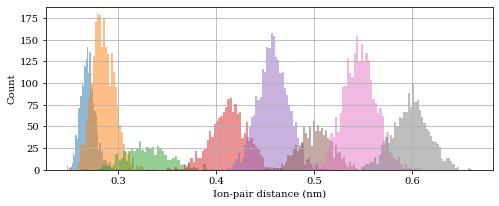

In [21]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

Notably, varying levels of uncertainty can arise at different CV values, which stem from different numbers of uncorrelated samples. For example, in the region characterized by an ion-pair distance of around 0.25 nm, the uncertainty is minimal. In contrast, in regions corresponding to an ion-pair distance exceeding 0.6 nm, we observe a significant increase in uncertainty. This increased uncertainty is mainly attributable to the paucity of uncorrelated samples in these regions.

Below is the code that I used to generate the figure in the article.

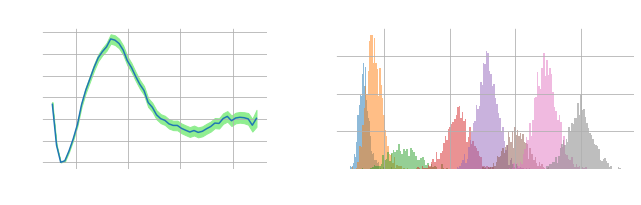

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 3-row x 9-column grid
gs = gridspec.GridSpec(nrows=3, ncols=9)

# Create the first subplot of size 4:3 
plt.figure(figsize=(9, 3))
ax1 = plt.subplot(gs[:, 0:4])
ax1.plot(bin_center_i, f_i)
ax1.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax1.set_xlabel('Ion-pair distance (nm)', color='white')
ax1.set_ylabel('Free energy (kT)', color='white')
ax1.grid()
plt.text(-0.1, 1.15, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

# Create the second subplot of size 8:3
ax2 = plt.subplot(gs[:, 4:9])
for i in range(8):
    ax2.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
ax2.set_xlabel('Ion-pair distance (nm)', color='white')
ax2.set_ylabel('Number of \nuncorrelated samples', color='white')
ax2.grid()
plt.text(-0.1, 1.15, 'B', transform=ax2.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

setup_coordinates(ax1, color='white')
setup_coordinates(ax2, color='white')
plt.tight_layout(w_pad=2)
plt.savefig('results/f_profile.png', transparent=True, dpi=600)

## 5. Additional exercises
In this section, we explore umbrella sampling simulations with different force constants to see how force constants change the spread of the CV distributions and the resulting free energy profile. For a more detailed description of the exercise, please refer to Exercise 3 in the article. 

### 5-1. Setting $k$ to $1000$ $\mathrm{kJ/mol/nm^2}$

In [23]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
# no need to modify k since k=1000 was also used in the pulling simulation

In [24]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
for i in {0..5}    # We only run simulations for 6 windows here, since the centers of the last two windows are too close to the upper bound. 
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp pull/NaCl.ndx sim_${i}/.       # This line is only needed for GROMACS with a version later than 2022
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

Setting the LD random seed to -539541251

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -268829079

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the re

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1/sim_0
Command line:
  gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_0.gro -r NaCl_0.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.

Notably, since the spread of the distributions will be wider given smaller force constants, here we only consider 6 windows centered from 0.25 up to 0.55 nm so that it is less likely to have configurations with an ion-pair distance exceeding half of the box length. 

In the code below, we will need to change the following parameters:
- The value of `K` (line 8)
- The value of `d_max` (line 12)
- The value of `nbins` (line 13)
- The values of `K_k` (line 14)

Note that we use a smaller number of bins because some regions may have very few samples. Using too many bins will possibly lead to bins with 0 samples. 

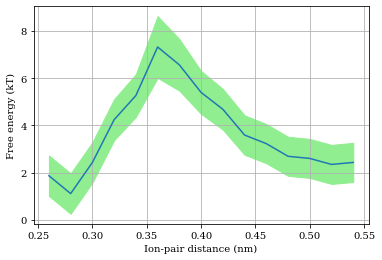

In [25]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

# Step 1: Setting up
K = 6                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.55                   # minimum and maximum of the CV for plotting the FES
nbins = 15                                  # number of bins for FES
K_k = np.ones(K) * 1000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes_1000.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

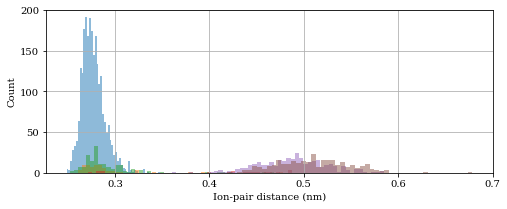

In [26]:
plt.figure(figsize=(8, 3))
for i in range(6):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

In [27]:
samples_small = uncorrelated_samples  # for plotting later

### 5-2. Setting $k$ to $50000$ $\mathrm{kJ/mol/nm^2}$

In [28]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 50000/g" NaCl_umbrella.mdp

In [29]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp pull/NaCl.ndx sim_${i}/.       # This line is only needed for GROMACS with a version later than 2022
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

Setting the LD random seed to -1107564614

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -136329218

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the r

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1/sim_0
Command line:
  gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_0.gro -r NaCl_0.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.

Note that in the code below, we only change the values of `nbins` (line 7) and `K_k` (line 8). 

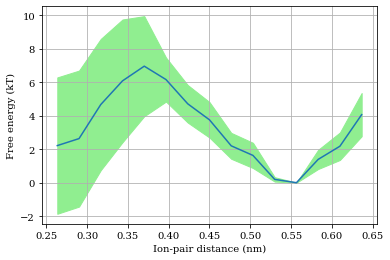

In [30]:
# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 15                                  # number of bins for FES
K_k = np.ones(K) * 50000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes_50000.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

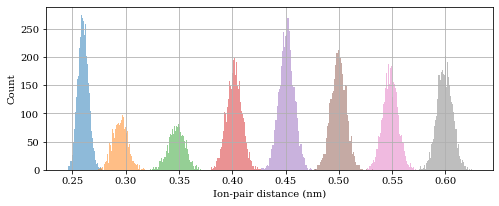

In [31]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

In [32]:
samples_large = uncorrelated_samples  # for plotting below

The following is the code I used to generate the figure in the article. 

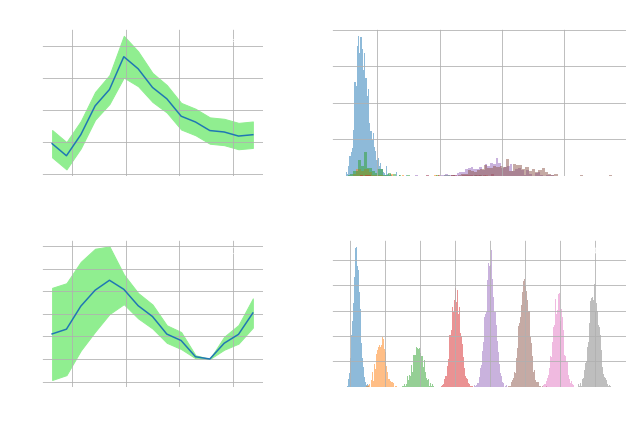

In [33]:
# Create a 6-row x 9-column grid
gs = gridspec.GridSpec(nrows=6, ncols=9)

# Create the figure
plt.figure(figsize=(9, 6))  # Adjust as needed

# Create the first subplot in the first row
f_i = np.transpose(np.loadtxt('results/fes_1000.dat'))[1]
df_i = np.transpose(np.loadtxt('results/fes_1000.dat'))[2]

ax1 = plt.subplot(gs[:3, :4]) 
ax1.plot(bin_center_i, f_i)
ax1.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax1.set_xlabel('Ion-pair distance (nm)', color='white')
ax1.set_ylabel('Free energy (kT)', color='white')
ax1.grid()
ax1.text(0.97, 0.95, 'k=500', transform=ax1.transAxes, va='top', ha='right', color='white')
plt.text(-0.1, 1.15, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

# Create the second subplot in the first row
ax2 = plt.subplot(gs[:3, 4:]) 
for i in range(6):
    ax2.hist(samples_small[i], bins=50, alpha=0.5)
ax2.set_xlabel('Ion-pair distance (nm)', color='white')
ax2.set_ylabel('Number of \nuncorrelated samples', color='white')
ax2.grid()
plt.text(0.97, 0.95, 'k=500', transform=ax2.transAxes, va='top', ha='right', color='white')
plt.text(-0.1, 1.15, 'B', transform=ax2.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

# Create the third subplot in the second row
f_i = np.transpose(np.loadtxt('results/fes_50000.dat'))[1]
df_i = np.transpose(np.loadtxt('results/fes_50000.dat'))[2]

ax3 = plt.subplot(gs[3:, :4])
ax3.plot(bin_center_i, f_i)
ax3.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax3.set_xlabel('Ion-pair distance (nm)', color='white')
ax3.set_ylabel('Free energy (kT)', color='white')
ax3.grid()
plt.text(0.97, 0.95, 'k=50000', transform=ax3.transAxes, va='top', ha='right', color='white')
plt.text(-0.1, 1.15, 'C', transform=ax3.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

# Create the fourth subplot in the second row
ax4 = plt.subplot(gs[3:, 4:]) 
for i in range(8):
    ax4.hist(samples_large[i], bins=50, alpha=0.5)
ax4.set_xlabel('Ion-pair distance (nm)', color='white')
ax4.set_ylabel('Number of \nuncorrelated samples', color='white')
ax4.grid()
plt.text(0.97, 0.95, 'k=50000', transform=ax4.transAxes, va='top', ha='right', color='white')
plt.text(-0.1, 1.15, 'D', transform=ax4.transAxes, fontweight='bold', va='top', ha='right', color='white', fontsize=16)

setup_coordinates(ax1, color='white')
setup_coordinates(ax2, color='white')
setup_coordinates(ax3, color='white')
setup_coordinates(ax4, color='white')
plt.tight_layout(w_pad=2)
plt.savefig('results/f_profile_compare.png', transparent=True, dpi=600)